# Introduction

This notebook uses T-SNE to visualize the Dice distances term and structure occurrences in documents. Documents are colored by their domain assignments in each framework.

# Load the data

In [1]:
import pandas as pd
import numpy as np

import sys
sys.path.append("..")
import utilities
from style import style

## Brain activation coordinates

In [2]:
act_bin = utilities.load_coordinates()
print("Document N={}, Structure N={}".format(
      act_bin.shape[0], act_bin.shape[1]))

Document N=18155, Structure N=118


## Term occurrences

In [3]:
frameworks = ["data-driven", "data-driven", "rdoc", "dsm"]
suffixes = ["_lr", "_nn", "_opsim", "_opsim"]
lists, words = {}, []
for framework, suffix in zip(frameworks, suffixes):
    lists[framework] = pd.read_csv("../ontology/lists/lists_{}{}.csv".format(framework, suffix), index_col=None)
    words += list(lists[framework]["TOKEN"])

In [4]:
words = sorted(list(set(words)))
len(words)

281

In [5]:
dtm_bin = utilities.load_doc_term_matrix(version=190325, binarize=True)
print("Document N={}, Term N={}".format(
      dtm_bin.shape[0], dtm_bin.shape[1]))

Document N=18155, Term N=4107


## Structure-term vectors

In [6]:
pmids = act_bin.index.intersection(dtm_bin.index)
len(pmids)

18155

In [7]:
act_bin = act_bin.loc[pmids]
dtm_bin = dtm_bin.loc[pmids]

In [8]:
vecs = act_bin.copy()
vecs[words] = dtm_bin[words]
vecs.shape

(18155, 399)

In [9]:
splits = {}
splits["discovery"] = [int(pmid.strip()) for pmid in open("../data/splits/train.txt")]
splits["replication"] = [int(pmid.strip()) for pmid in open("../data/splits/validation.txt")]
splits["replication"] += [int(pmid.strip()) for pmid in open("../data/splits/test.txt")]
for split, pmids in splits.items():
    print("{:12s} N={}".format(split.title(), len(pmids)))

Discovery    N=12708
Replication  N=5447


## Domain assignments

In [10]:
suffix

'_opsim'

In [11]:
partition_suffixes = ["_lr", "_nn", "", ""]
partitions = {framework + suffix: pd.read_csv("../partition/data/doc2dom_{}{}.csv".format(
                                     framework, suffix), index_col=0, header=None) 
              for framework, suffix in zip(frameworks, partition_suffixes)}

# Reduce dimensions with PCA

In [12]:
from sklearn.decomposition import PCA

In [13]:
pca = PCA(n_components=None, copy=True, whiten=False, svd_solver="auto", 
          tol=0.0, iterated_power="auto", random_state=42)

In [14]:
X_pca = pca.fit_transform(vecs)

In [15]:
X_pca.shape

(18155, 399)

# Fit a T-SNE model

In [16]:
import os
from sklearn.manifold import TSNE

In [17]:
perplexity = 25.0
early_exaggeration = 15.0
learning_rate = 500.0
n_iter = 1000
PCs = 10

In [18]:
tsne = TSNE(n_components=2, perplexity=perplexity, early_exaggeration=early_exaggeration, 
            learning_rate=learning_rate, n_iter=n_iter, n_iter_without_progress=300, 
            min_grad_norm=1e-07, metric="cosine", init="random", verbose=0, 
            random_state=42, method="barnes_hut", angle=0.5)

In [19]:
outfile = "data/tsne_{}pcs_perp{}_exag{}_lr{}_iter{}.csv".format(
          PCs, int(perplexity), int(early_exaggeration), int(learning_rate), int(n_iter))
if not os.path.exists(outfile):
    X = tsne.fit_transform(X_pca[:,:PCs])
    X_df = pd.DataFrame(X, index=vecs.index, columns=["X", "Y"])
    X_df.to_csv(outfile)
else:
    X = pd.read_csv(outfile, index_col=0, header=0).values

# Plot the results

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
domain2order = {}
for framework in frameworks:
    domain2order[framework] = {}
    for domain in style.order[framework]:
        domain2order[framework][domain] = style.order[framework].index(domain)

In [22]:
colors = {}
for framework, suffix in zip(frameworks, partition_suffixes):
    key = framework + suffix
    colors[key] = {}
    for split in splits:
        colors[key][split] = []
        for pmid in vecs.index:
            if pmid in splits[split]:
                domain = partitions[key].loc[pmid].values[0]
                idx = domain2order[framework][domain]
                colors[key][split].append(style.palettes[framework][idx])
            else:
                colors[key][split].append("none")

In [23]:
shapes = ["o", "v", "^", ">", "<", "s", "X", "D", "p"]

In [24]:
markers = {}
for framework, suffix in zip(frameworks, partition_suffixes):
    key = framework + suffix
    markers[key] = []
    for pmid in vecs.index:
        domain = partitions[key].loc[pmid].values[0]
        idx = domain2order[framework][domain]
        markers[key].append(shapes[idx])

In [25]:
def plot_tsne(framework, split, suffix="", print_fig=True):
    
    fig, ax = plt.subplots(figsize=(8,8))
    
    key = framework + suffix
    
    for i in range(X.shape[0]):
        plt.scatter(X[i,0], X[i,1], c=colors[key][split][i], 
                    marker=markers[key][i], alpha=0.525, s=13)
    
    for side in ["top", "bottom", "left", "right"]:
        ax.spines[side].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.tight_layout()
    plt.savefig("figures/tsne_{}_{}pcs_perp{}_exag{}_lr{}_iter{}_{}.png".format(key, PCs,
                int(perplexity), int(early_exaggeration), int(learning_rate), int(n_iter), split), dpi=250)
    
    if print_fig:
        plt.show()
    plt.close()

## Data-driven

Plotting discovery set


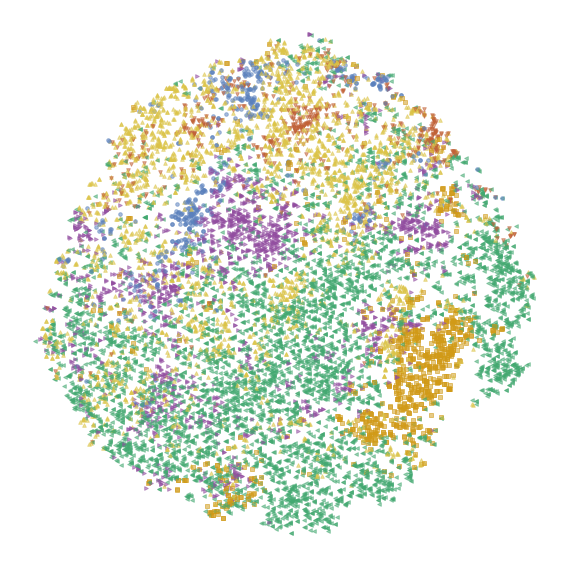

Plotting replication set


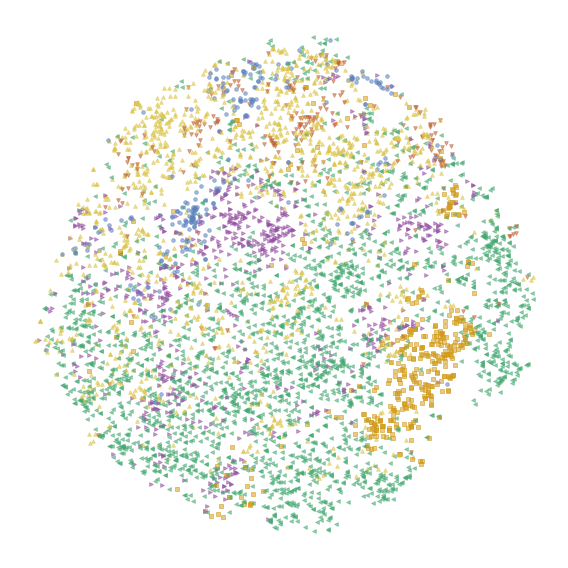

In [26]:
for split in splits.keys():
    print("Plotting {} set".format(split))
    plot_tsne("data-driven", split, suffix="_lr")

Plotting discovery set


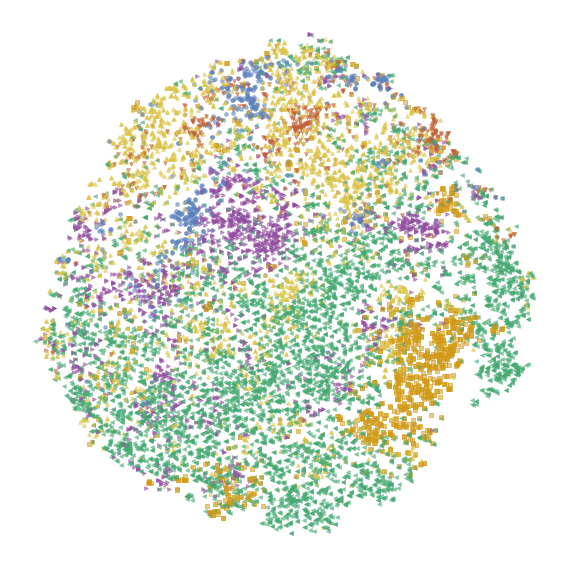

Plotting replication set


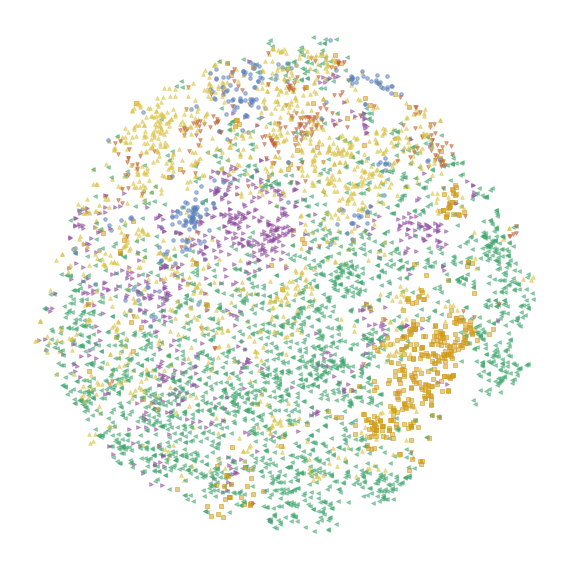

In [27]:
for split in splits.keys():
    print("Plotting {} set".format(split))
    plot_tsne("data-driven", split, suffix="_nn")

## RDoC

Plotting discovery set


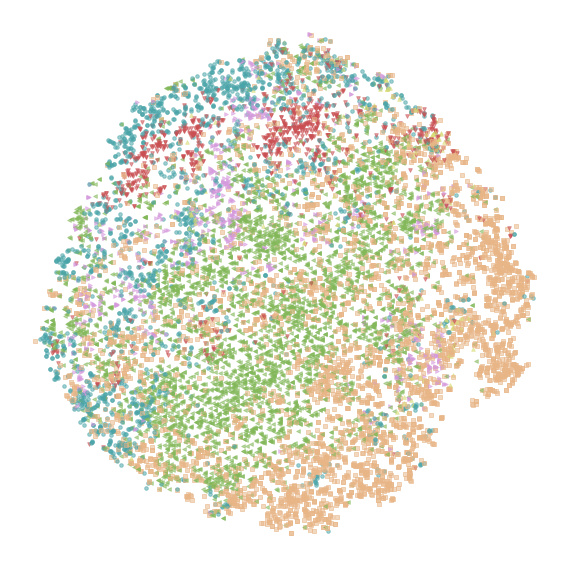

Plotting replication set


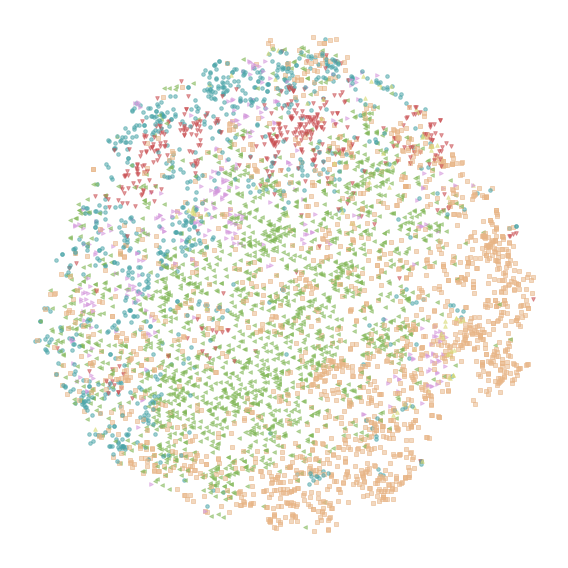

In [28]:
for split in splits.keys():
    print("Plotting {} set".format(split))
    plot_tsne("rdoc", split)

## DSM

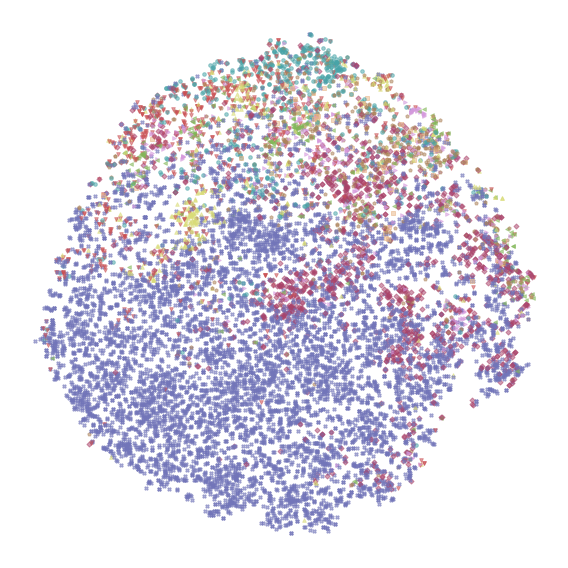

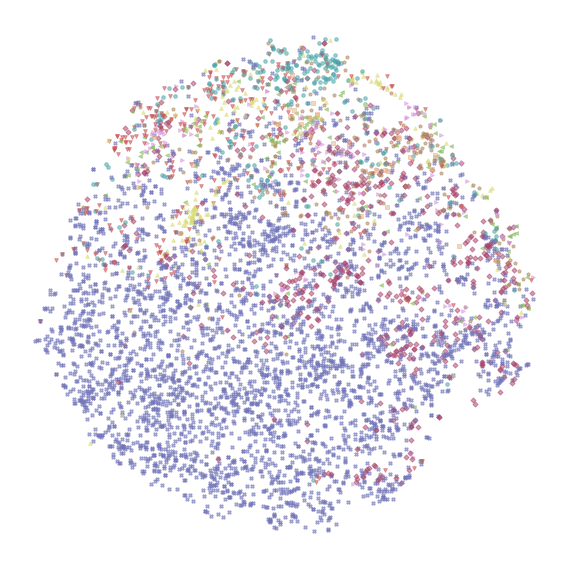

In [29]:
for split, split_pmids in splits.items():
    plot_tsne("dsm", split)